### Visual Text Composer

<b>Overview: </b> Image-Captioning model using the Flickr8k dataset. We'll preprocess the data, extract image features using ResNet50, define a captioning model with LSTM, train the model, and finally generate captions for new images.<br><br>

1. Importing Necessary Libraries
2. Data Loading and Preprocessing
    2.1. Loading Captions
    2.2. Visualizing Sample Images and Captions
    2.3. Text Preprocessing
    2.4. Tokenization
    2.5. Train-Test Split

3. Feature Extraction
4. Data Generator
5. Model Definition
6. Model Training
7. Inference
    7.1. Caption Generation
    7.2. Visualization of Generated Captions
8. BELU Score

#### 1. Importing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pickle

import warnings

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Dropout, 
                                     add, concatenate, Flatten)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau)
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-11-15 07:04:58.678622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731665098.693690 1686657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731665098.698250 1686657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 07:04:58.714619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 2. Data Loading and Preprocessing

#### 2.1. Loading Captions

In [3]:
# Paths to the dataset
IMAGE_DIR = './Images'  # Directory where images are stored

CAPTIONS_FILE = "./captions.txt"  # File containing image captions

# Load captions
data = pd.read_csv(CAPTIONS_FILE)
display(data.head())

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


#### 2.2. Visualizing Sample Images and Captions

In [4]:
# Function to load and preprocess an image
def read_image(image_path, img_size=224):
    """
    Loads and preprocesses an image.
    Args:
        image_path (str): Path to the image file.
        img_size (int): Desired image size (height and width).
    Returns:
        np.array: Preprocessed image array.
    """
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to display sample images and their captions
def display_images(df, num_images=15):
    """
    Displays a grid of images with their corresponding captions.
    Args:
        df (pd.DataFrame): DataFrame containing image filenames and captions.
        num_images (int): Number of images to display.
    """
    df = df.sample(num_images).reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(5, 3, i + 1)
        image_path_full = os.path.join(IMAGE_DIR, df['image'][i])
        image = read_image(image_path_full)
        plt.imshow(image)
        plt.title("\n".join(wrap(df['caption'][i], 20)), fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Uncomment the following line to display images
# display_images(data, num_images=15)

#### 2.3. Text Preprocessing

In [5]:
import re

# Function to preprocess captions
def preprocess_captions(df):
    """
    Cleans the caption text data.
    Args:
        df (pd.DataFrame): DataFrame containing captions.
    Returns:
        pd.DataFrame: DataFrame with cleaned captions.
    """
    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        text = re.sub(r'\b\w\b', '', text)  # Remove single characters
        return text

    df['caption'] = df['caption'].apply(clean_text)
    df['caption'] = df['caption'].apply(lambda x: f"startseq {x} endseq")  # Add start and end tokens
    return df

# Clean the caption text
data = preprocess_captions(data)
display(data.head())

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up ...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden pl...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going int...


#### 2.4. Tokenization

In [6]:
# Fit a tokenizer on the cleaned captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])

# Get the vocabulary size and maximum caption length
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

max_length = max(len(caption.split()) for caption in data['caption'])
print(f"Maximum Caption Length: {max_length}")

Vocabulary Size: 8768
Maximum Caption Length: 34


#### 2.5. Train-Test Split

In [7]:
# Split the dataset into training and validation sets
unique_images = data['image'].unique().tolist()
n_total = len(unique_images)
print(f"Total Unique Images: {n_total}")

train_images, val_images = train_test_split(
    unique_images,
    test_size=0.15,  # 15% for validation
    random_state=42,
    shuffle=True
)

print(f"Number of Training Images: {len(train_images)}")
print(f"Number of Validation Images: {len(val_images)}")

train_df = data[data['image'].isin(unique_images)].reset_index(drop=True)
val_df = data[data['image'].isin(val_images)].reset_index(drop=True)

print(f"Training Set: {train_df.shape[0]} captions")
print(f"Validation Set: {val_df.shape[0]} captions")


Total Unique Images: 8091
Number of Training Images: 6877
Number of Validation Images: 1214
Training Set: 40455 captions
Validation Set: 6070 captions


#### 3. Feature Extraction

In [8]:
def create_sequences(tokenizer, max_length, df):
    X2, y, image_names = list(), list(), list()
    vocab_size = len(tokenizer.word_index) + 1

    for i in tqdm(range(len(df))):
        img_name = df.iloc[i]['image']
        caption = df.iloc[i]['caption']

        seq = tokenizer.texts_to_sequences([caption])[0]
        for j in range(1, len(seq)):
            in_seq, out_seq = seq[:j], seq[j]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            X2.append(in_seq)
            y.append(out_seq)
            image_names.append(img_name)

    return np.array(X2), np.array(y), np.array(image_names)

# X2_train, y_train, image_names_train = create_sequences(tokenizer, max_length, train_df) # Precompute sequences for training set
# X2_val, y_val, image_names_val = create_sequences(tokenizer, max_length, val_df) # Precompute sequences for validation set


In [9]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tqdm import tqdm

class DataGenerator(Sequence):
    def __init__(self, df, tokenizer, max_length, feature_extractor, batch_size=64, img_size=224, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.feature_extractor = feature_extractor
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.vocab_size = len(tokenizer.word_index) + 1

        self.seq_lengths = []
        for caption in tqdm(self.df['caption'], desc="Calculating sequence lengths"):
            seq = tokenizer.texts_to_sequences([caption])[0]
            self.seq_lengths.append(len(seq) - 1)

        self.cum_seq_lengths = np.cumsum([0] + self.seq_lengths)
        self.total_sequences = self.cum_seq_lengths[-1]
        self.indexes = np.arange(self.total_sequences)
        self.image_feature_cache = {}  # Initialize cache here
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.total_sequences / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_X1 = []
        batch_X2 = []
        batch_y = []

        for index in batch_indexes:
            caption_idx = np.searchsorted(self.cum_seq_lengths, index, side='right') - 1
            position_in_caption = index - self.cum_seq_lengths[caption_idx]

            img_name = self.df.iloc[caption_idx]['image']
            caption = self.df.iloc[caption_idx]['caption']

            if img_name in self.image_feature_cache:
                feature = self.image_feature_cache[img_name]
            else:
                img_path = os.path.join(IMAGE_DIR, img_name)
                try:
                    img = load_img(img_path, target_size=(self.img_size, self.img_size))
                    img = img_to_array(img)
                    img = np.expand_dims(img, axis=0)
                    img = preprocess_input(img)
                    feature = self.feature_extractor.predict(img, verbose=0)
                    feature = feature.flatten()
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    feature = np.zeros((2048,))
                self.image_feature_cache[img_name] = feature

            seq = self.tokenizer.texts_to_sequences([caption])[0]
            in_seq = seq[:position_in_caption + 1]
            out_seq = seq[position_in_caption + 1]
            in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post', truncating='post')[0]
            out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

            batch_X1.append(feature)
            batch_X2.append(in_seq)
            batch_y.append(out_seq)

        batch_X1 = np.array(batch_X1)
        batch_X2 = np.array(batch_X2)
        batch_y = np.array(batch_y)

        # Return a tuple instead of a list for inputs
        return (batch_X1, batch_X2), batch_y


#### 4. Create training and validation data generators

In [10]:
# Initialize the feature extractor model
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Create training and validation data generators without precomputing sequences
train_generator = DataGenerator(
    df=train_df,
    tokenizer=tokenizer,
    max_length=max_length,
    feature_extractor=feature_extractor,
    batch_size=64,
    img_size=224,
    shuffle=True
)

val_generator = DataGenerator(
    df=val_df,
    tokenizer=tokenizer,
    max_length=max_length,
    feature_extractor=feature_extractor,
    batch_size=64,
    img_size=224,
    shuffle=False
)

I0000 00:00:1731665101.873133 1686657 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1122 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:03:00.0, compute capability: 8.6
I0000 00:00:1731665101.873596 1686657 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6110 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:04:00.0, compute capability: 8.6
Calculating sequence lengths: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6070/6070 [00:00<00:00, 109411.14it/s]


#### 5. Model Definition

In [11]:
# Define the model architecture
image_input = Input(shape=(2048,), name='image_input')
image_dense = Dense(256, activation='relu')(image_input)
image_dropout = Dropout(0.015)(image_dense)

caption_input = Input(shape=(max_length,), name='caption_input')
caption_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(caption_input)
caption_dropout = Dropout(0.015)(caption_embedding)
caption_lstm0 = LSTM(1024, return_sequences=True)(caption_embedding)
caption_lstm1 = LSTM(512, return_sequences=True)(caption_lstm0)
caption_lstm2 = LSTM(256)(caption_lstm1)

# Combine image features and caption sequences
decoder = add([image_dense, caption_lstm2])
hnn0 = Dense(1024, activation='relu')(decoder)
hnn1 = Dense(1024, activation='relu')(hnn0)
hnn2 = Dense(512, activation='relu')(hnn1)
decoder_dense = Dense(256, activation='relu')(hnn2)
output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Compile the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,244,608 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 34, 1024)  │  5,246,976 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 34, 512)   │  3,147,776 │ lstm[0][0],       │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    787,456 │ lstm_1[0][0],     │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │    263,168 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  1,049,600 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8768)      │  2,253,376 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,173,632 (61.70 MB)

 Trainable params: 16,173,632 (61.70 MB)

 Non-trainable params: 0 (0.00 B)

#### 6. Model Training

In [12]:
# Define callbacks for model training
model_name = "best_model_resnet50b.keras"

checkpoint = ModelCheckpoint(
    model_name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,
    verbose=1,
    min_lr=1e-7
)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

I0000 00:00:1731665107.087476 1686823 service.cc:148] XLA service 0x7f3ba4049c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731665107.087530 1686823 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1731665107.087537 1686823 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-15 07:05:07.208239: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731665107.645302 1686823 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1731665109.327254 1686823 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/50
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1833 - loss: 5.0170
Epoch 1: val_loss improved from inf to 3.85932, saving model to best_model_resnet50b.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 969s 148ms/step - accuracy: 0.1833 - loss: 5.0169 - val_accuracy: 0.2813 - val_loss: 3.8593 - learning_rate: 0.0010
Epoch 2/50
6458/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2834 - loss: 3.8200
Epoch 2: val_loss improved from 3.85932 to 3.50530, saving model to best_model_resnet50b.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 172s 27ms/step - accuracy: 0.2834 - loss: 3.8200 - val_accuracy: 0.3096 - val_loss: 3.5053 - learning_rate: 0.0010
Epoch 3/50
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3069 - loss: 3.5192
Epoch 3: val_loss improved from 3.50530 to 3.32616, saving model to best_model_resnet50b.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 175s 27ms/step - accuracy: 0.3069 - loss: 3.5192 - val_accuracy: 0.3225 - val_loss: 3.3262 - learning_rate: 0.0010
Epoch 4/50
6

6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3755 - loss: 2.7873
Epoch 22: val_loss improved from 2.73600 to 2.72336, saving model to best_model_resnet50b.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 182s 28ms/step - accuracy: 0.3755 - loss: 2.7873 - val_accuracy: 0.3842 - val_loss: 2.7234 - learning_rate: 0.0010
Epoch 23/50
6458/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3770 - loss: 2.7877
Epoch 23: val_loss did not improve from 2.72336
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 187s 29ms/step - accuracy: 0.3770 - loss: 2.7877 - val_accuracy: 0.3817 - val_loss: 2.7388 - learning_rate: 0.0010
Epoch 24/50
6458/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3774 - loss: 2.7814
Epoch 24: val_loss did not improve from 2.72336
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 187s 29ms/step - accuracy: 0.3774 - loss: 2.7814 - val_accuracy: 0.3829 - val_loss: 2.7379 - learning_rate: 0.0010
Epoch 25/50
6457/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3775 - loss: 2.7812
Epoch 25: val_loss did

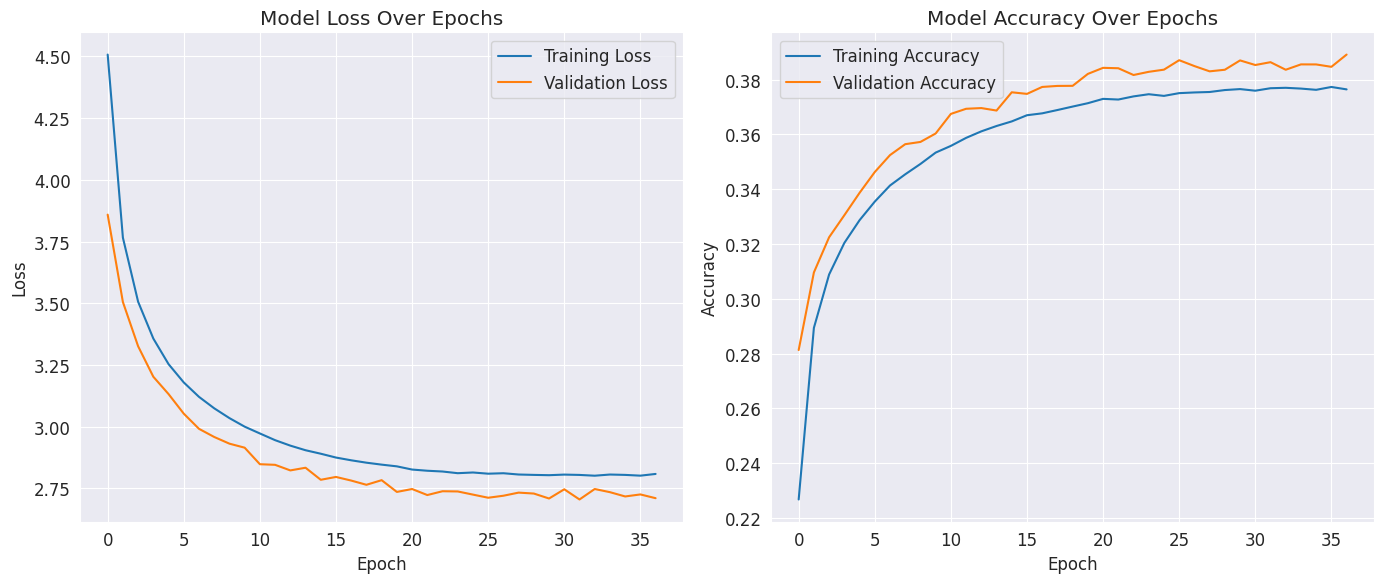

In [15]:
# Plot training and validation loss and accuracy over epochs
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### 7. Inference

#### 7.1. Caption Generation

In [16]:
# Function to map token index to its corresponding word
def idx_to_word(integer, tokenizer):
    """
    Maps an integer to its corresponding word.
    Args:
        integer (int): Token index.
        tokenizer (Tokenizer): Fitted Keras Tokenizer instance.
    Returns:
        str or None: Corresponding word or None if not found.
    """
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, feature_extractor):
    """
    Generates a caption for a given image.
    Args:
        model (keras.Model): Trained captioning model.
        image (str): Filename of the image.
        tokenizer (Tokenizer): Fitted Keras Tokenizer instance.
        max_length (int): Maximum length of captions.
        feature_extractor (keras.Model): Model for feature extraction.
    Returns:
        str: Generated caption.
    """
    img_path = os.path.join(IMAGE_DIR, image)
    try:
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = feature_extractor.predict(img, verbose=0)
        feature = feature.flatten()
    except Exception as e:
        print(f"Error processing {image}: {e}")
        return "Image processing error."
    
    in_text = "startseq"
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')
    
        y_pred = model.predict([feature.reshape(1, -1), sequence], verbose=0)
        y_pred = np.argmax(y_pred)
    
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
    
        in_text += f" {word}"
    
        if word == 'endseq':
            break
    
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]  # Remove 'startseq' and 'endseq'
    final_caption = ' '.join(final_caption)
    return final_caption


#### 7.2. Visualization of Generated Captions

In [17]:
# Function to visualize generated captions for a set of images
def visualize_generated_captions(model, df, tokenizer, max_length, feature_extractor, num_samples=15):
    """
    Displays images with their generated captions in a grid layout.
    Args:
        model (keras.Model): Trained captioning model.
        df (pd.DataFrame): DataFrame containing image filenames and true captions.
        tokenizer (Tokenizer): Fitted Keras Tokenizer instance.
        max_length (int): Maximum length of captions.
        feature_extractor (keras.Model): Model for feature extraction.
        num_samples (int): Number of samples to display.
    """
    samples = df.sample(num_samples).reset_index(drop=True)
    
    cols = 3
    rows = (num_samples + cols - 1) // cols
    plt.figure(figsize=(20, 5 * rows))
    
    for i in range(num_samples):
        img_name = samples.loc[i, 'image']
        true_caption = samples.loc[i, 'caption']

        predicted_caption = predict_caption(model, img_name, tokenizer, max_length, feature_extractor)

        img_path = os.path.join(IMAGE_DIR, img_name)
        try:
            image = read_image(img_path)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            continue

        # Plot the image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_caption}\nPredicted: {predicted_caption}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualize generated captions for a few examples
visualize_generated_captions(model, val_df, tokenizer, max_length, feature_extractor, num_samples=4)


In [ ]:
## BLEU Scoring
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
chencherry = SmoothingFunction()
references = []
hypotheses = []
for img_name in tqdm(val_images, desc="Calculating BLEU scores"):
    img_captions = val_df[val_df['image'] == img_name]['caption'].tolist()
    img_captions_clean = [caption.replace('startseq', '').replace('endseq', '').strip().split() for caption in img_captions]
    references.append(img_captions_clean)  # List of lists of tokens

    predicted_caption = predict_caption(model, img_name, tokenizer, max_length, feature_extractor)
    predicted_caption_tokens = predicted_caption.strip().split()
    hypotheses.append(predicted_caption_tokens)
bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1)
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method1)
bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
print(f"BLEU-1 Score: {bleu1*100:.2f}")
print(f"BLEU-2 Score: {bleu2*100:.2f}")
print(f"BLEU-3 Score: {bleu3*100:.2f}")
print(f"BLEU-4 Score: {bleu4*100:.2f}")

[nltk_data] Downloading package punkt to /home/maxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Calculating BLEU scores: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1214/1214 [18:00<00:00,  1.12it/s]


BLEU-1 Score: 49.64
BLEU-2 Score: 30.88
BLEU-3 Score: 18.82
BLEU-4 Score: 10.88
